In [174]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [175]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [176]:
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")

In [177]:
df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [179]:
df = df.dropna(subset=["bytes_in", "bytes_out"])
df["creation_time"] = pd.to_datetime(df["creation_time"])
df["end_time"] = pd.to_datetime(df["end_time"])

In [180]:
df["session_duration"] = (df["end_time"] - df["creation_time"]).dt.total_seconds()
df["avg_packet_size"] = (df["bytes_in"] + df["bytes_out"]) / (df["session_duration"] + 1)

In [181]:
features = df[["bytes_in", "bytes_out", "session_duration", "avg_packet_size"]]

In [182]:
model = IsolationForest(contamination=0.05, random_state=42)
df["anomaly"] = model.fit_predict(features)
df["anomaly"] = df["anomaly"].map({1: "Normal", -1: "Suspicious"})

In [183]:
print(df["anomaly"].value_counts())
print(df[df["anomaly"] == "Suspicious"].head())

anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64
     bytes_in  bytes_out             creation_time                  end_time  \
36    4190330     283456 2024-04-25 23:30:00+00:00 2024-04-25 23:40:00+00:00   
87    1215594      64362 2024-04-26 00:30:00+00:00 2024-04-26 00:40:00+00:00   
116   4827283     306181 2024-04-26 01:00:00+00:00 2024-04-26 01:10:00+00:00   
132   1889834      34306 2024-04-26 01:20:00+00:00 2024-04-26 01:30:00+00:00   
153   4869181     301752 2024-04-26 01:40:00+00:00 2024-04-26 01:50:00+00:00   

             src_ip src_ip_country_code protocol  response.code  dst_port  \
36    155.91.45.242                  US    HTTPS            200       443   
87   165.225.240.79                  NL    HTTPS            200       443   
116   155.91.45.242                  US    HTTPS            200       443   
132  165.225.240.79                  NL    HTTPS            200       443   
153   155.91.45.242                  US    HTTPS            200 

In [184]:
df['duration_seconds'] = (df['end_time']-df['creation_time']).dt.total_seconds()

In [185]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['bytes_in', 'bytes_out', 'duration_seconds']])

In [186]:
from sklearn.preprocessing import OneHotEncoder

# Assuming df_unique is your DataFrame (e.g., df_unique = df.drop_duplicates())

# Correct OneHotEncoder initialization
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
encoded_features = encoder.fit_transform(df[['src_ip_country_code']])

# Optional: Convert to DataFrame for readability
import pandas as pd
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['src_ip_country_code']))

print("Encoded features shape:", encoded_features.shape)
print("Sample encoded features:")
print(encoded_df.head())


Encoded features shape: (282, 7)
Sample encoded features:
   src_ip_country_code_AE  src_ip_country_code_AT  src_ip_country_code_CA  \
0                     1.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     1.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   src_ip_country_code_DE  src_ip_country_code_IL  src_ip_country_code_NL  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     1.0   

   src_ip_countr

In [187]:
scaled_columns = ['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration_seconds']
encoded_columns =encoder.get_feature_names_out(['src_ip_country_code'])

In [188]:
scaled_df = pd.DataFrame(scaled_features, columns=scaled_columns, index=df.index)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=df.index)


In [189]:
transformed_df=pd.concat([df,scaled_df,encoded_df], axis=1)

In [190]:
transformed_df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,...,scaled_bytes_in,scaled_bytes_out,scaled_duration_seconds,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,...,-0.288219,-0.281223,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,...,-0.282108,-0.260804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,...,-0.282689,-0.279344,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,...,-0.282197,-0.276161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,...,-0.287996,-0.277678,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [191]:
numeric_df = transformed_df.select_dtypes(include=['float64', 'int64'])
correlation_matrix_numeric = numeric_df.corr()

In [192]:
correlation_matrix_numeric

,bytes_in,bytes_out,response.code,dst_port,session_duration,avg_packet_size,duration_seconds,scaled_bytes_in,scaled_bytes_out,scaled_duration_seconds,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
bytes_in,1.000000,0.997705,NaN,NaN,NaN,0.999992,NaN,1.000000,0.997705,NaN,-0.070559,-0.081670,-0.166488,-0.095333,-0.065939,-0.006827,0.316015
bytes_out,0.997705,1.000000,NaN,NaN,NaN,0.997963,NaN,0.997705,1.000000,NaN,-0.072452,-0.081777,-0.159587,-0.090001,-0.067630,-0.045641,0.327683
response.code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dst_port,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
session_duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_packet_size,0.999992,0.997963,NaN,NaN,NaN,1.000000,NaN,0.999992,0.997963,NaN,-0.070677,-0.081687,-0.166109,-0.095036,-0.066045,-0.009075,0.316730
duration_seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scaled_bytes_in,1.000000,0.997705,NaN,NaN,NaN,0.999992,NaN,1.000000,0.997705,NaN,-0.070559,-0.081670,-0.166488,-0.095333,-0.065939,-0.006827,0.316015
scaled_bytes_out,0.997705,1.000000,NaN,NaN,NaN,0.997963,NaN,0.997705,1.000000,NaN,-0.072452,-0.081777,-0.159587,-0.090001,-0.067630,-0.045641,0.327683
scaled_duration_seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


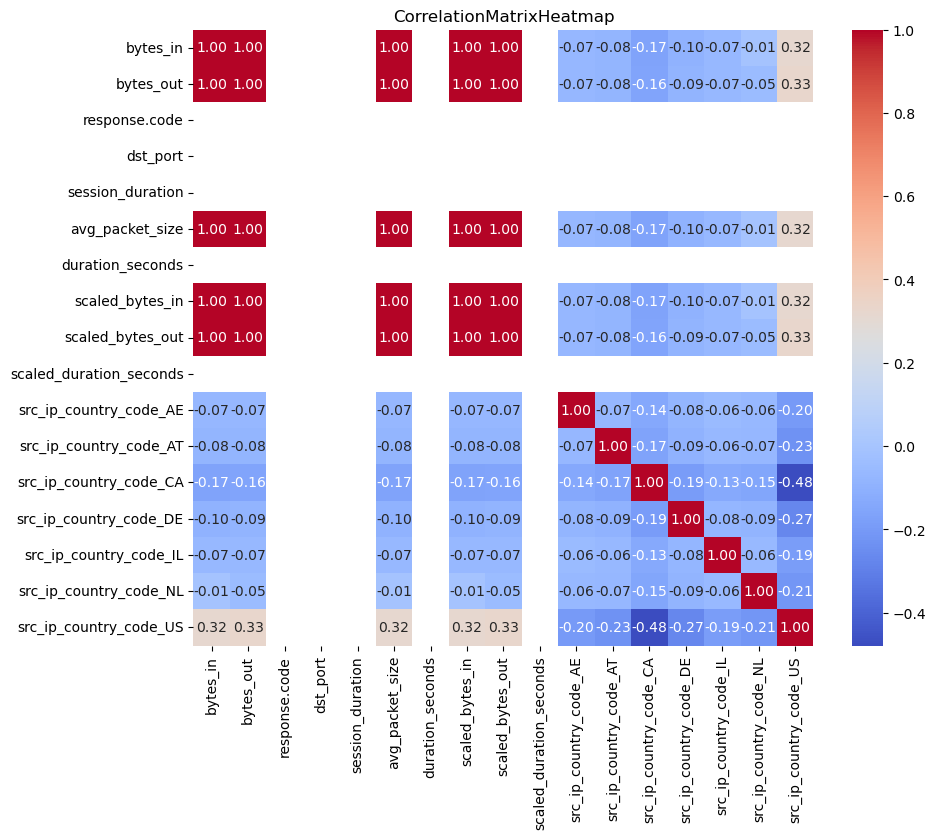

In [193]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_numeric,annot=True,fmt=".2f", cmap='coolwarm')
plt.title('CorrelationMatrixHeatmap')
plt.show()

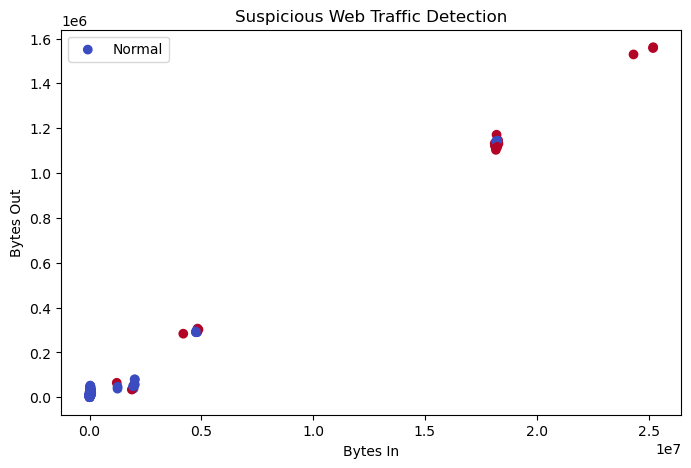

In [194]:
plt.figure(figsize=(8, 5))
plt.scatter(df["bytes_in"], df["bytes_out"],
            c=(df["anomaly"] == "Suspicious"),
            cmap="coolwarm", label="Anomaly")
plt.xlabel("Bytes In")
plt.ylabel("Bytes Out")
plt.title("Suspicious Web Traffic Detection")
plt.legend(["Normal", "Suspicious"])
plt.show()

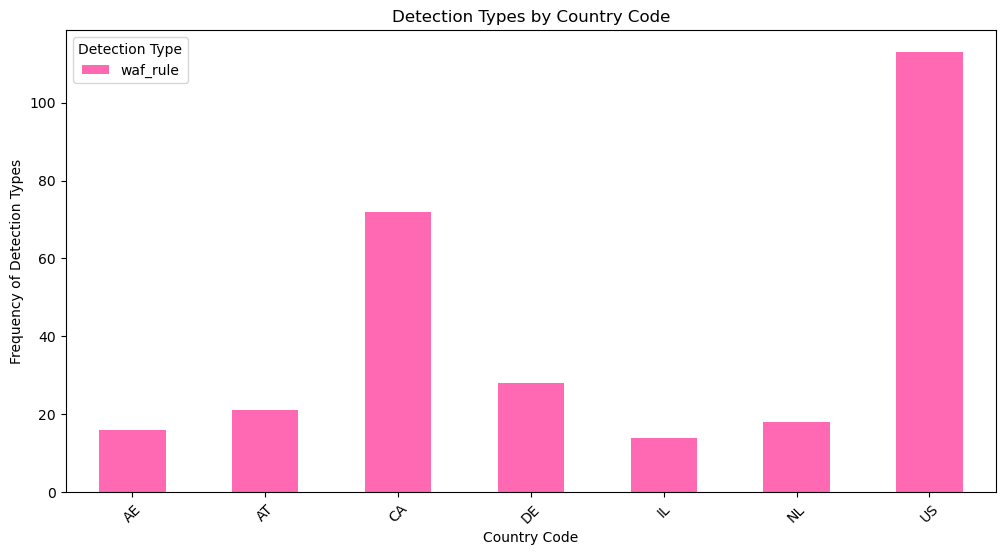

In [195]:
detection_by_country =pd.crosstab(transformed_df['src_ip_country_code'], transformed_df['detection_types'])
detection_by_country.plot(kind='bar', stacked=True, figsize=(12, 6),color = 'hotpink')
plt.title('Detection Types by Country Code')
plt.xlabel('Country Code')
plt.ylabel('Frequency of Detection Types')
plt.xticks(rotation=45)
plt.legend(title='Detection Type')
plt.show()

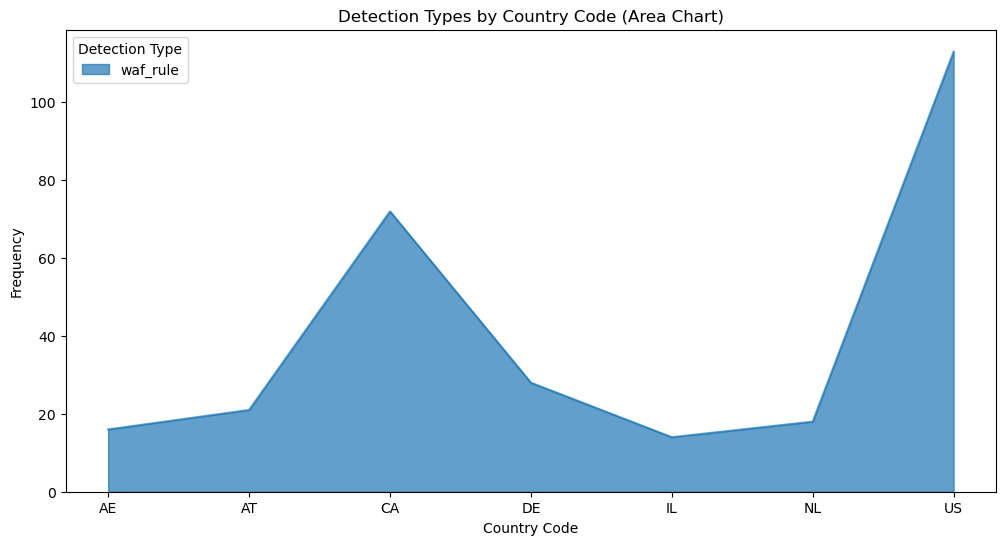

In [196]:
detection_by_country.plot(kind='area', stacked=True, figsize=(12, 6), alpha=0.7)
plt.title('Detection Types by Country Code (Area Chart)')
plt.xlabel('Country Code')
plt.ylabel('Frequency')
plt.legend(title='Detection Type')
plt.show()

In [197]:
df['creation_time'] = pd.to_datetime(df['creation_time'])

In [198]:
df.set_index('creation_time', inplace=True)

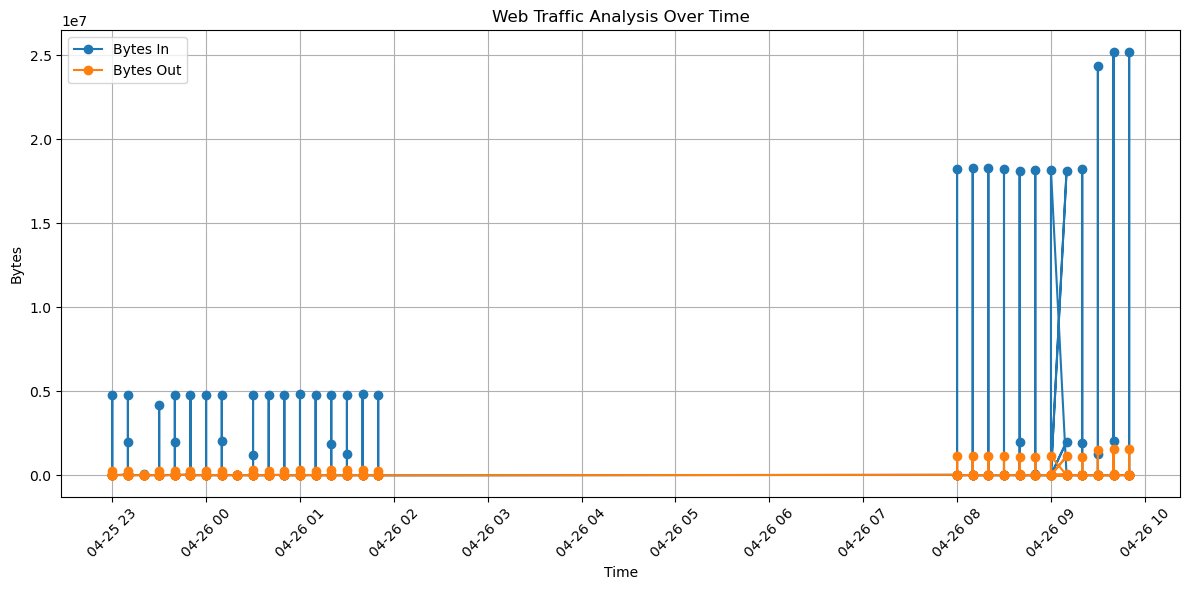

In [199]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['bytes_in'], label='Bytes In', marker='o')
plt.plot(df.index, df['bytes_out'], label='Bytes Out', marker='o')
plt.title('Web Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


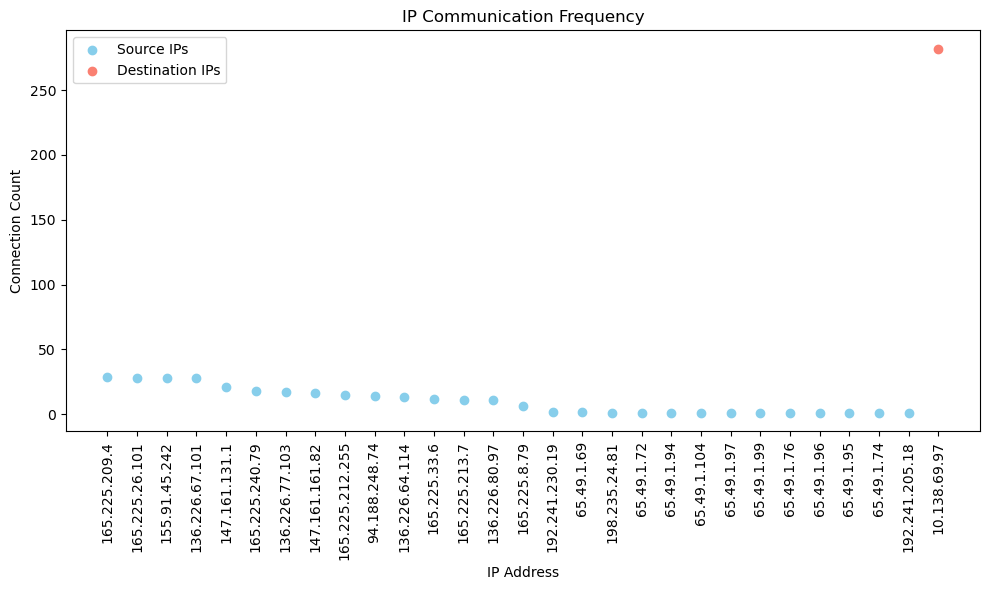

In [200]:
import matplotlib.pyplot as plt

src_counts = df['src_ip'].value_counts()
dst_counts = df['dst_ip'].value_counts()

plt.figure(figsize=(10,6))
plt.scatter(src_counts.index, src_counts.values, color='skyblue', label='Source IPs')
plt.scatter(dst_counts.index, dst_counts.values, color='salmon', label='Destination IPs')
plt.title('IP Communication Frequency')
plt.xlabel('IP Address')
plt.ylabel('Connection Count')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

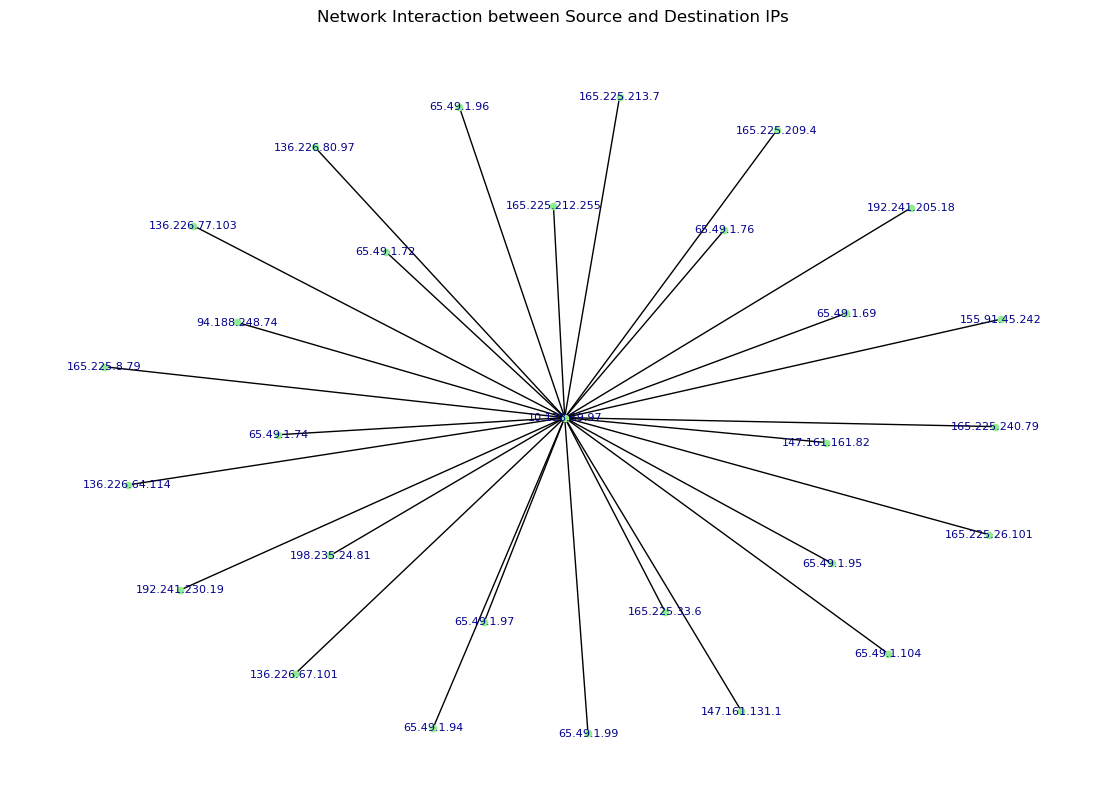

In [217]:
G = nx.Graph()
 
for idx, row in df.iterrows():
     G.add_edge(row['src_ip'], row['dst_ip'])

plt.figure(figsize=(14, 10))
nx.draw_networkx(G, with_labels=True, node_size=20, font_size=8, node_color='LIGHTGREEN', font_color='darkblue')
plt.title('Network Interaction between Source and Destination IPs')
plt.axis('off') 
plt.show()

In [202]:
 transformed_df['is_suspicious'] =(transformed_df['detection_types'] == 'waf_rule').astype(int)

 X = transformed_df[['bytes_in', 'bytes_out', 'scaled_duration_seconds']] 
 y = transformed_df['is_suspicious']

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
 
rf_classifier.fit(X_train, y_train)
 
y_pred = rf_classifier.predict(X_test)

In [204]:
accuracy = accuracy_score(y_test, y_pred)
classification = classification_report(y_test, y_pred)

In [205]:
print("Model Accuracy: ",accuracy)

Model Accuracy:  1.0


In [206]:
 print("Classification Report: ",classification)

Classification Report:                precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



In [207]:
df['is_suspicious'] = (df['detection_types'] =='waf_rule').astype(int)

In [208]:
# Assuming data is your cleaned DataFrame (e.g., data = df)

# Features: bytes_in and bytes_out (using only numeric features)
X = df[['bytes_in', 'bytes_out']].values
y = df['is_suspicious'].values

# Optional: Verify
print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (282, 2)
Target shape: (282,)


In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [210]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [211]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming X_train_scaled, X_test_scaled, y_train, y_test are defined from previous steps

model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Train the model (fit is training)
print("Model trained.")

# Evaluate the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Model trained.
Test Accuracy: 100.00%


In [212]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming X_train_scaled, X_test_scaled, y_train, y_test are defined from previous steps

model = RandomForestClassifier(n_estimators=128, max_depth=10, random_state=42)  # Simulating deeper model with regularization
model.fit(X_train_scaled, y_train)

# Train the model (fit is training)
print("Model trained.")

# Evaluate the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Summary
print("Model summary:")
print(f"Number of estimators: {model.n_estimators}")
print(f"Max depth: {model.max_depth}")


Model trained.
Test Accuracy: 100.00%
Model summary:
Number of estimators: 128
Max depth: 10


In [213]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming model is already defined as RandomForestClassifier, and X_train_scaled, X_test_scaled, y_train, y_test are defined

# No compile needed for Scikit-learn
# Train the model
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 100.00%


In [214]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming model is already defined as RandomForestClassifier, and X_train_scaled, X_test_scaled, y_train, y_test are defined

# No compile needed for Scikit-learn
# Train the model
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 100.00%


TensorFlow is already installed.
Loading and preprocessing data...

Training Dense Neural Network...
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4076 - loss: 0.7007 - val_accuracy: 0.4500 - val_loss: 0.6708
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5096 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6688
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5478 - loss: 0.6862 - val_accuracy: 0.4500 - val_loss: 0.6726
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4777 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6713
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5350 - loss: 0.6793 - val_accuracy: 0.4500 - val_loss: 0.6770
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5605 - loss: 0.6866 - val_accuracy: 0.4500 - val_loss: 0.6810
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5414 - loss: 0.6945 - val_accuracy: 0.4500 - val_loss: 0.6878
Epoch 8/10
5/5 ━━━━━━━━━

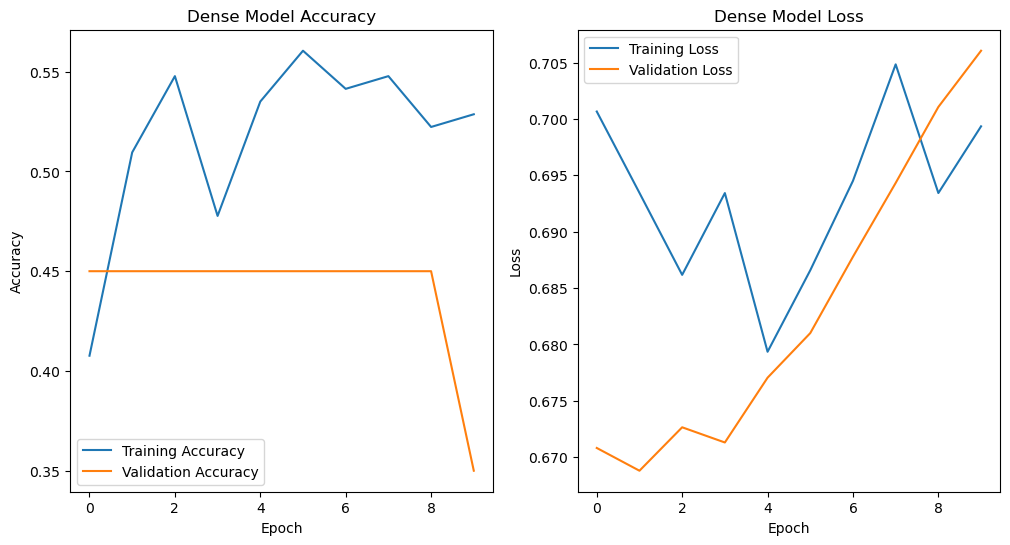


Training Convolutional Neural Network...
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4586 - loss: 0.7019 - val_accuracy: 0.5250 - val_loss: 0.7484
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4459 - loss: 0.6981 - val_accuracy: 0.4000 - val_loss: 0.7487
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5159 - loss: 0.6972 - val_accuracy: 0.4000 - val_loss: 0.7392
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5414 - loss: 0.6950 - val_accuracy: 0.4000 - val_loss: 0.7307
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5350 - loss: 0.6936 - val_accuracy: 0.4000 - val_loss: 0.7249
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5350 - loss: 0.6925 - val_accuracy: 0.3500 - val_loss: 0.7173
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5605 - loss: 0.6900 - val_accuracy: 0.3500 - val_loss: 0.7121
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5032 - loss: 0.6997 

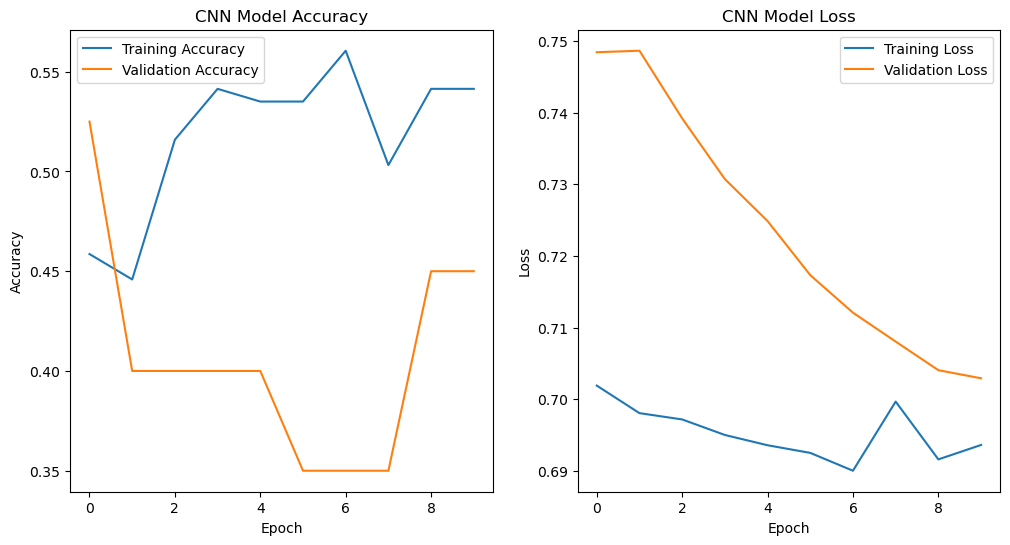


Training and evaluation complete!


In [215]:
# Complete Combined Code for CloudWatch Traffic Attack Detection with Auto-Installation

import subprocess
import sys

# Step 0: Check and Install TensorFlow if Missing
try:
    import tensorflow as tf
    print("TensorFlow is already installed.")
except ImportError:
    print("TensorFlow not found. Attempting to install...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
        print("TensorFlow installed successfully. Restart your kernel/session and re-run this cell.")
        sys.exit()  # Exit to force restart
    except subprocess.CalledProcessError:
        print("Failed to install TensorFlow automatically. Please install manually: pip install tensorflow")
        sys.exit()

# Now import other libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Step 1: Data Loading and Preprocessing
print("Loading and preprocessing data...")
data = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')

# Select relevant numerical features
features = ['bytes_in', 'bytes_out', 'dst_port']
X = data[features].values

# Simulate binary target (1 for suspicious, 0 otherwise; replace with actual logic, e.g., y = (data['rule_names'] == 'Suspicious Web Traffic').astype(int))
y = np.random.randint(0, 2, size=len(X))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Dense Neural Network Model
print("\nTraining Dense Neural Network...")
model_dense = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_dense.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history_dense = model_dense.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

loss_dense, accuracy_dense = model_dense.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy_dense*100:.2f}%")

# Plotting for Dense Model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dense.history['accuracy'], label='Training Accuracy')
plt.plot(history_dense.history['val_accuracy'], label='Validation Accuracy')
plt.title('Dense Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_dense.history['loss'], label='Training Loss')
plt.plot(history_dense.history['val_loss'], label='Validation Loss')
plt.title('Dense Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 3: Convolutional Neural Network Model
print("\nTraining Convolutional Neural Network...")
# Reshape for Conv1D (add channel dimension)
X_train_scaled_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

model_cnn = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(X_train_scaled_cnn.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train_scaled_cnn, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test_scaled_cnn, y_test)
print(f"Test Accuracy: {accuracy_cnn*100:.2f}%")

# Plotting for CNN Model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("\nTraining and evaluation complete!")